## ESI at AMO
# Figure: diffraction patterns

In [1]:
%pylab inline
import pickle, os
import condor, spimage, h5py
from matplotlib.colors import LogNorm

Populating the interactive namespace from numpy and matplotlib


/Users/max.hantke/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Convenience function for reading and local caching of XFEL data from Davinci

In [2]:
davinci_mount = "/Users/max.hantke/davinci"

cache_filename = "./cache.p"
do_clear_cache = False
if not os.path.exists(cache_filename) or do_clear_cache:
    with open(cache_filename, "w") as f:
        pickle.dump({}, f)

def read_data(run, i, i0=0, sort=True):
    if isinstance(i, list):
        i_list = i
    else:
        i_list = [i]
    
    with open(cache_filename, "r") as f:
        C = pickle.load(f)
    
    if run in C:
        R = C[run]
    else:
        R = _read_metadata_from_davinci(run)

    mask = R["mask"]
    images = []
    for _i in i_list:
        if sort:
            _i_ds = R["i_sorted"][i0+_i]
        else:
            _i_ds = i0+_i
        if _i_ds in R["images"]:
            print "Load data from cache"
            img = R["images"][_i_ds]
        else:
            print "Load data from davinci"
            img = _read_image_from_davinci(run, _i_ds)
            R["images"][_i_ds] = img
        images.append(img)
    images = asarray(images)
    
    C[run] = R
    with open(cache_filename, "w") as f:
        pickle.dump(C, f)

    return mask, images
           
def _read_metadata_from_davinci(run):
    with h5py.File("%s/scratch/fhgfs/xray/amol3416/preproc_201611/amol3416_r%04i_ol3.h5" % (davinci_mount, run), "r") as f:
        mask = array(f["/entry_1/data_1/mask"])
        hitscores = array(f["/entry_1/result_1/hitscore_litpixel"])
        i_sorted = hitscores.argsort()[::-1]
    return {"mask": mask, "i_sorted" : i_sorted, "images": {}}
        
def _read_image_from_davinci(run, i):
    with h5py.File("%s/scratch/fhgfs/xray/amol3416/preproc_201611/amol3416_r%04i_ol3.h5" % (davinci_mount, run), "r") as f:
        image = array(f["/entry_1/data_1/data"][i], dtype="f")
    return image

## 1) TBSV

### Read data

In [3]:
# TBSV
run_tbsv = 135
i_list_tbsv = [11,12,10,9]
mask_tbsv, images_tbsv = read_data(run_tbsv, i=i_list_tbsv)

Load data from cache
Load data from cache
Load data from cache
Load data from cache


### Simulation

In [4]:
wl = condor.source.Photon(energy_eV=800.).get_wavelength()
S = condor.Source(wavelength=wl, focus_diameter=3.E-6, pulse_energy=0.05*1E-3)
ds = 8
D_distance = 0.25
D = condor.Detector(distance=D_distance, pixel_size=75E-6*ds, nx=1024/ds, ny=1024/ds)

# Single
P1 = condor.ParticleSphere(diameter=35E-9, material_type="cell")#, rotation_formalism='random')
E1 = condor.Experiment(S, {"particle_sphere": P1}, D)
res1 = E1.propagate()
in1 = res1['entry_1']['data_1']['data']
rs1 = spimage.crop(abs(fftshift(ifftn(fftshift(res1['entry_1']['data_1']['data_fourier'])))), 20)
#imshow(in1)

# Double
P2 = condor.ParticleSphere(diameter=35E-9, material_type="cell", position=[0.,0.,0.], position_variation_n=[2,1,1], position_spread=[35E-9,0.,0.], position_variation="range", number=2)
D = condor.Detector(distance=D_distance, pixel_size=75E-6*ds, nx=1024/ds, ny=1024/ds)
E2 = condor.Experiment(S, {"particle_sphere": P2}, D)
res2 = E2.propagate()
in2 = res2['entry_1']['data_1']['data']
rs2 = spimage.crop(abs(fftshift(ifftn(fftshift(res2['entry_1']['data_1']['data_fourier'])))), 20)
#imshow(in2)

### Plot real data and simulation

/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


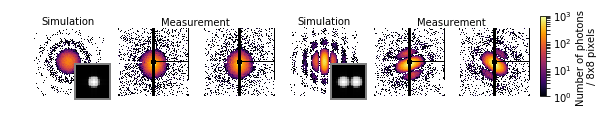

In [5]:
from matplotlib.font_manager import FontProperties
font_b = FontProperties().copy()
font_b.set_weight('bold')
font_n = FontProperties().copy()


sf = 0.4
fw = sf*20
fh = sf*4
fr = fw/fh
fig= figure(figsize=(fw,fh))
Nax = 6
w = 1/float(2.2+Nax)
h = 0.9
x0 = linspace(0.01, 0.75, Nax)
y0 = 0.05

axs = [fig.add_axes([x0i,y0,w,h]) for x0i in x0]
axs_is = [fig.add_axes([x0[0]+w*0.6,y0+0.05,w*0.5,h*0.5]),
          fig.add_axes([x0[3]+w*0.6,y0+0.05,w*0.5,h*0.5]),]
axc = fig.add_axes([0.75+w*1.15, 0.2, 0.01, 0.7])

cmap = 'inferno'
for ax,data in zip([axs[0],axs[3]],[in1, in2]):
    img = array(poisson(data), dtype='float')
    im = ax.imshow(img, norm=LogNorm(1, 1000), interpolation="nearest", cmap=cmap)
    ax.set_axis_off()
for ax,i in zip([axs[1],axs[2],axs[4], axs[5]],range(len(images_tbsv))):
    img = images_tbsv[i]/200.
    img[img<1] = 0
    img, msk = spimage.binImage(img, ds, msk=mask_tbsv==0, output_binned_mask=True)
    ax.imshow(img, norm=LogNorm(1, 1000), cmap=cmap, interpolation="nearest")
    ax.imshow(log10((1-msk)*10), cmap="binary_r")
    ax.set_axis_off()
colorbar(mappable=im, cax=axc, label="Number of photons \n/ %ix%i pixels" % (ds, ds))
for ax,data in zip(axs_is, [rs1,rs2]):
    ax.imshow(data, cmap='binary_r', interpolation='nearest')
    plt.setp(ax.spines.values(), color="gray", lw=2)
    ax.set_xticks([])
    ax.set_yticks([])
    
#axs[0].annotate("a", (0.,1.2), xycoords="axes fraction",ha="right", va="top", fontproperties=font_b)
axs[0].annotate("Simulation", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
axs[1].annotate("Measurement", (1.1,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
#axs[3].annotate("b", (0.,1.2), xycoords="axes fraction",ha="right", va="top", fontproperties=font_b)
axs[3].annotate("Simulation", (0.5,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)
axs[4].annotate("Measurement", (1.1,1.15), xycoords="axes fraction",ha="center", va="top", fontproperties=font_n)

savefig("patterns_tbsv.png", dpi=600)

## 2) Carboxysomes

### Read data

In [6]:
# CBX
run_cbx = 127
i_list_cbx = [3,4,5,9,10]
mask_cbx, images_cbx = read_data(run_cbx, i=i_list_cbx)

Load data from cache
Load data from cache
Load data from cache
Load data from cache
Load data from cache


### Simulation

In [7]:
wl = condor.source.Photon(energy_eV=800.).get_wavelength()
S = condor.Source(wavelength=wl, focus_diameter=3.E-6, pulse_energy=0.05*1E-3)
ds = 1
D = condor.Detector(distance=0.250, pixel_size=75E-6*ds, nx=1024/ds, ny=1024/ds)
PI = condor.ParticleMap(diameter=100E-9, material_type="cell", geometry="icosahedron", rotation_formalism='random')
EI = condor.Experiment(S, {"particle_map": PI}, D)
resI = EI.propagate()
inI = resI['entry_1']['data_1']['data']
rsI = spimage.crop(abs(fftshift(ifftn(fftshift(resI['entry_1']['data_1']['data_fourier'])))), 20)
#imshow(log10(poisson(abs(inI))))

### Plot real data and simulation

(1024, 1024)


/Users/max.hantke/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


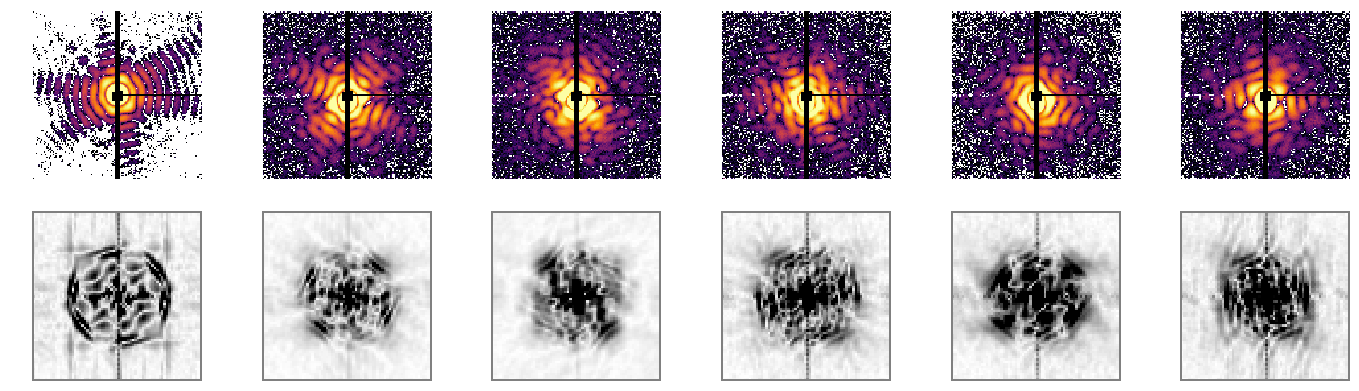

In [9]:
sf = 4
fig, (axs_top, axs_bot) = subplots(2,6, figsize=(sf*6,sf*1.7))
ii = ["sim"] + range(5)
cmap = 'inferno'
for i,ax1,ax2 in zip(ii,axs_top,axs_bot):
    if i != "sim":
        I0 = images_cbx[i]
        I = I0/240.
        I[I<0.5] = 0
    else:
        I0 = array(poisson(inI), dtype=float64)
        I = I0
    M = mask_cbx==0
    I = spimage.crop(I, cropLength=1024)
    M = spimage.crop(M, cropLength=1024)
    img, msk = spimage.binImage(I, 8, msk=M, output_binned_mask=True)
    img[img<0.5] = 0
    #ax1.imshow(zeros_like(img), vmin=0, vmax=1, cmap=cmap)
    ax1.imshow(img, norm=LogNorm(1,1000), cmap=cmap, interpolation="nearest")
    ax1.imshow(log10((1-msk)*10), cmap="binary_r")
    ax1.set_axis_off()
    P, out = spimage.patterson(image=I, mask=M, floor_cut=0.5, subtract_fourier_kernel=True, mask_smooth=1., 
                               radial_boost=True,
                               gauss_damp=True, gauss_damp_sigma=150., gauss_damp_threshold=5.,
                               #darkfield_x=50, darkfield_y=50, darkfield_sigma=150., darkfield_N=4,
                               mask_expand=1.,
                               full_output=True)
    Psmall = spimage.crop(abs(P),70)
    ax2.imshow(Psmall, vmax=Psmall.max()/10., vmin=0, cmap='binary')
    #ax2.set_axis_off()
    plt.setp(ax2.spines.values(), color="gray", lw=2)
    ax2.set_xticks([])
    ax2.set_yticks([])
savefig("patterns_cbx.png", dpi=400, transparent=True)

## 3) Rubisco

### Read data

In [ ]:
# Rubisco
run_rub = 150
#i0 = 0
#mask_rub, images_rub = read_data(run_rubisco, N=30, i0=i0, sort=True)